# Download dataset with Pytorch



## Load the data

In [55]:
import random

import torch
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
from PIL import Image

def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [56]:
set_random_seed(143)
# Define transformation for each image
transform = transforms.Compose([
    # transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Lambda(lambda x: np.array(x).flatten())  #Stretch image into row [32,32,3] -> [3072]
])

# Download a CIFAR10 dataset
dataset = datasets.CIFAR10("/datasets",
                           train=True,
                           transform=transform,
                           download=True)

Files already downloaded and verified


## Split dataset & define dataloaders

torch.Size([256, 3072]) torch.Size([256])
tensor([ 86,  87,  75,  ..., 171, 202, 225], dtype=torch.uint8)


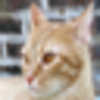

3

In [57]:
train_ds, val_ds, _ = random_split(dataset, [20000, 1000, 29000])
# Hint: Perform debug on smaller subset

batch_size = 256

train_loader = DataLoader(train_ds, batch_size=batch_size)
val_loader = DataLoader(val_ds, batch_size=batch_size)

# Display one image
for images, class_nums in train_loader:
    print(images.shape, class_nums.shape)  # class_nums are tensor!
    print(images[0])
    display(Image.fromarray(images[0].reshape((32, 32, 3)).numpy()).resize(size=(100, 100)), class_nums[0].item())
    break


# Implement LinearClassifier class for CIFAR10

Реализация с 2 и 1 циклами

In [58]:
# Two cycle imp

# loss = 0.0
# dW1 = np.zeros(self.W.shape)
#
# for i in range(len(X)):
#     scores = X[i].dot(self.W)
#     fine_class_score = scores[int(y[i])]
#
#     above_zero_count = 0
#     for j in range(self.classes_num):
#         if j == int(y[i]):
#             continue
#
#         margin = scores[j] - fine_class_score + self.margin_delta
#         if margin > 0:
#             above_zero_count += 1
#             loss += margin
#             dW1[:, j] += X[i]
#
#     dW1[:, y[i]] -= above_zero_count * X[i]
#
# loss /= len(X)
# print(loss)

# print(np.sum(dW, axis=0))

# One cycle imp

# loss = 0
# dW = np.zeros(self.W.shape)
#
# for i in range(5):
#     scores = X[i].dot(self.W)
#     margins = np.maximum(0, scores - scores[y[i]] + self.margin_delta)
#     margins[y[i]] = 0
#
#     non_zero_margins = margins != 0
#     incorrect_count = non_zero_margins.sum()
#     dW[:, non_zero_margins] += X[i].reshape(-1, 1)
#     dW[:, y[i]] -= incorrect_count * X[i]
#
#     loss += np.sum(margins)
#
#
# loss /= len(X)
# print(loss)
# print(np.sum(dW, axis=0))


Реализация без циклов

In [59]:
from numpy import linalg as LA

class LinearClassifier:
    def __init__(self, labels, margin_delta=20, l2_coef=0.1, lr=2e-9):
        self.margin_delta = margin_delta
        self.labels = labels
        self.classes_num = len(labels)
        # Generate a random weight matrix of small numbers
        # You can change this code
        self.W = np.random.randn(3073, self.classes_num) * 0.0001
        self.l2_coef = l2_coef
        self.lr = lr

    def train(self, X_batch, y_batch):
        """
          Arguments:
            x  (numpy.array): collection of objects (batch)
            y  (numpy.array): collection of integer
            representing a class number for objects from x
        """
        X_batch = self._add_ones(X_batch)
        loss_val, grad = self.loss(X_batch, y_batch)
        self.W -= self.lr * grad

        return loss_val / X_batch.shape[0]

    def loss(self, X, y):  # x and y are batches
        """
          Arguments:
            x  (numpy.array): collection of objects (batch)
            y  (numpy.array): collection of integer
            representing a class number for objects from x

        """

        # Zero!! cycle imp

        scores = X.dot(self.W)
        margins = np.maximum(0, scores - scores[np.arange(len(scores)), y].reshape(-1, 1) + self.margin_delta)
        margins[np.arange(len(margins)), y] = 0
        loss = np.sum(margins) / len(X) + LA.norm(self.W)
        margins[margins > 0] = 1
        # Use count of incorrect by row

        margins[np.arange(len(margins)), y] = -np.sum(margins, axis=1).T # To (256, 1)
        dW = np.dot(X.T, margins) + 2 * self.l2_coef * self.W

        return loss, dW

    def _add_ones(self, X):
        return np.hstack([X, np.ones((X.shape[0], 1))])

    def predict(self, X):
        X = self._add_ones(X)
        scores = X.dot(self.W)  # (256, 3073) * (3073, 10)
        return np.argmax(scores, axis=1)

# Train model

## Function for accuracy checking

Don't change this code

In [60]:
from sklearn.metrics import accuracy_score


def validate(model, dataloader):
    y_predicted = np.array([])
    y_gtrue = np.array([])
    for images, class_nums in dataloader:
        index = model.predict(images.numpy())
        y_predicted = np.append(y_predicted, index)
        y_gtrue = np.append(y_gtrue, class_nums.numpy())
    return accuracy_score(y_gtrue, y_predicted)

## Train loop
Let's train our model

In [61]:
import tqdm

model = LinearClassifier(dataset.classes)
best_accuracy = 0
for epoch in range(25):
    for images, class_nums in tqdm.tqdm(train_loader):
        loss = model.train(images.numpy(), class_nums.numpy())
        accuracy = validate(model, val_loader)
    if best_accuracy < accuracy:
        best_accuracy = accuracy
    print(f"Epoch {epoch} Loss: {loss}, Accuracy:{accuracy}")

print(f"Best accuracy is {best_accuracy}")

100%|██████████| 79/79 [00:06<00:00, 12.70it/s]


Epoch 0 Loss: 2.947315086231087, Accuracy:0.293


100%|██████████| 79/79 [00:06<00:00, 12.98it/s]


Epoch 1 Loss: 2.6625195212049695, Accuracy:0.31


100%|██████████| 79/79 [00:06<00:00, 12.98it/s]


Epoch 2 Loss: 2.547583252424404, Accuracy:0.317


100%|██████████| 79/79 [00:06<00:00, 13.03it/s]


Epoch 3 Loss: 2.47777548845732, Accuracy:0.315


100%|██████████| 79/79 [00:06<00:00, 12.98it/s]


Epoch 4 Loss: 2.41461329800527, Accuracy:0.32


100%|██████████| 79/79 [00:06<00:00, 12.92it/s]


Epoch 5 Loss: 2.3939019457877686, Accuracy:0.32


100%|██████████| 79/79 [00:06<00:00, 12.96it/s]


Epoch 6 Loss: 2.3745542750154924, Accuracy:0.32


100%|██████████| 79/79 [00:06<00:00, 12.91it/s]


Epoch 7 Loss: 2.352883812996582, Accuracy:0.322


100%|██████████| 79/79 [00:06<00:00, 12.96it/s]


Epoch 8 Loss: 2.3280352026606583, Accuracy:0.326


100%|██████████| 79/79 [00:06<00:00, 12.88it/s]


Epoch 9 Loss: 2.3249279173534845, Accuracy:0.33


100%|██████████| 79/79 [00:06<00:00, 12.91it/s]


Epoch 10 Loss: 2.3147814914461113, Accuracy:0.328


100%|██████████| 79/79 [00:06<00:00, 12.86it/s]


Epoch 11 Loss: 2.3046153297776004, Accuracy:0.327


100%|██████████| 79/79 [00:06<00:00, 12.76it/s]


Epoch 12 Loss: 2.297151820220468, Accuracy:0.327


100%|██████████| 79/79 [00:06<00:00, 12.93it/s]


Epoch 13 Loss: 2.2788806476524304, Accuracy:0.326


100%|██████████| 79/79 [00:06<00:00, 12.89it/s]


Epoch 14 Loss: 2.2686280824498084, Accuracy:0.326


100%|██████████| 79/79 [00:06<00:00, 12.82it/s]


Epoch 15 Loss: 2.2626191884195266, Accuracy:0.323


100%|██████████| 79/79 [00:06<00:00, 12.88it/s]


Epoch 16 Loss: 2.2480210618655057, Accuracy:0.323


100%|██████████| 79/79 [00:06<00:00, 12.81it/s]


Epoch 17 Loss: 2.244094083024461, Accuracy:0.325


100%|██████████| 79/79 [00:06<00:00, 12.37it/s]


Epoch 18 Loss: 2.2477380409830268, Accuracy:0.32


100%|██████████| 79/79 [00:06<00:00, 12.67it/s]


Epoch 19 Loss: 2.249307760921542, Accuracy:0.324


100%|██████████| 79/79 [00:06<00:00, 12.91it/s]


Epoch 20 Loss: 2.2436975784235567, Accuracy:0.318


100%|██████████| 79/79 [00:06<00:00, 12.90it/s]


Epoch 21 Loss: 2.24659178963932, Accuracy:0.321


100%|██████████| 79/79 [00:06<00:00, 12.93it/s]


Epoch 22 Loss: 2.231244802773384, Accuracy:0.323


100%|██████████| 79/79 [00:06<00:00, 12.56it/s]


Epoch 23 Loss: 2.2218704565859793, Accuracy:0.318


100%|██████████| 79/79 [00:06<00:00, 12.04it/s]

Epoch 24 Loss: 2.222063159006046, Accuracy:0.321
Best accuracy is 0.33


# Check model on test dataset

You must get accuracy above 0.35


In [63]:
test_dataset = datasets.CIFAR10('/datasets',
                                train=False,
                                transform=transform,  # Transforms stay the same
                                download=True)

test_loader = DataLoader(test_dataset, batch_size=batch_size)

accuracy = validate(model, test_loader)
print(f"Accuracy on test:{accuracy}")


Files already downloaded and verified
Accuracy on test:0.374


# Place for brief conclusion
Feel free to describe troubles here.

**Вывод**:
Реализовал SVM классификатор с помощью 2х циклов, 1 цикла, и главное - без циклов
Реализовал bias trick
Добавил L2-регуляризацию
Попробовал нормализовать данные (потом закомментировал трансформер). Обучение стало дольше (видимо операции вблизи нуля) и пришлось заново подбирать гиперпараметры

Не стал делать Кросс-Энтропию так как не очень понял, как это работает
Не сделал кросс-валидацию, хоть и начинал, так как обучение выходило супер-долгим


# Ideas for extra work

- Implenment CrossEntropyLoss function -
- Implement bias trick +
- Add regularization to SVM loss +
- Find best learning rate and regularization strength using Cross-Validation -
- Normalize data +


